In [1]:
from multiprocessing import Pool

import os
import sys
# sys.stdout.flush() # For progress bar to not print a new line everytime
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER') or '/home/fne23_stjarnholm/master-project'}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm

results = []

result_folders = run_tools.get_all_result_dirs()

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

with Pool(8) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

100%|██████████| 4/4 [00:00<00:00, 18.71it/s]


In [2]:
# PLOT SETTINGS:
# FAST_REACTOR = True # True if epithermal, False if thermal

folder_name = f"plots"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filter for FAST_REACTOR
# df = df[df["FAST_REACTOR"] == FAST_REACTOR]

if df.empty:
    raise Exception("No results found!")

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,PARTITION_TEXT,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,seed
0,0.690462,0.000214,../results/RUNDATA_R4_1,True,QUARTER,30000,300,50,1.676380e+09,1.676380e+09,95.354,5617365633
1,0.690072,0.000213,../results/RUNDATA_R4_2,True,FULL,30000,300,50,1.676380e+09,1.676380e+09,94.278,1398395212
2,0.990567,0.000312,../results/RUNDATA_R4_3,False,QUARTER,30000,300,50,1.676380e+09,1.676380e+09,133.463,4697560088
3,0.990502,0.000312,../results/RUNDATA_R4_4,False,FULL,30000,300,50,1.676380e+09,1.676380e+09,129.975,2959531263


In [3]:
df["rel_err_k-eff-std"] = 100 * df["k-eff-std"] / df["k-eff"]

df["rho"] = (df["k-eff"] - 1) / df["k-eff"]
df["rho-std"] = df["k-eff-std"] / df["k-eff"]**2

df["rho-pcm"] = 1e5 * df["rho"]
df["rho-std-pcm"] = 1e5 * df["rho-std"]

df["rel-err_rho-std"] = np.abs(100 * df["rho-std"] / df["rho"])

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,PARTITION_TEXT,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,seed,rel_err_k-eff-std,rho,rho-std,rho-pcm,rho-std-pcm,rel-err_rho-std
0,0.690462,0.000214,../results/RUNDATA_R4_1,True,QUARTER,30000,300,50,1.676380e+09,1.676380e+09,95.354,5617365633,0.030986,-0.448307,0.000449,-44830.653828,44.877773,0.100105
1,0.690072,0.000213,../results/RUNDATA_R4_2,True,FULL,30000,300,50,1.676380e+09,1.676380e+09,94.278,1398395212,0.030837,-0.449125,0.000447,-44912.509849,44.686967,0.099498
2,0.990567,0.000312,../results/RUNDATA_R4_3,False,QUARTER,30000,300,50,1.676380e+09,1.676380e+09,133.463,4697560088,0.031482,-0.009523,0.000318,-952.314408,31.781410,3.337281
3,0.990502,0.000312,../results/RUNDATA_R4_4,False,FULL,30000,300,50,1.676380e+09,1.676380e+09,129.975,2959531263,0.031541,-0.009589,0.000318,-958.888138,31.843649,3.320893


In [4]:
# pivot the dataframe from long to wide form
pivoted_df_k_eff = df.pivot(index='PARTITION_TEXT', columns='FAST_REACTOR', values='k-eff')
pivoted_df_t_elapsed = df.pivot(index='PARTITION_TEXT', columns='FAST_REACTOR', values='t_elapsed')

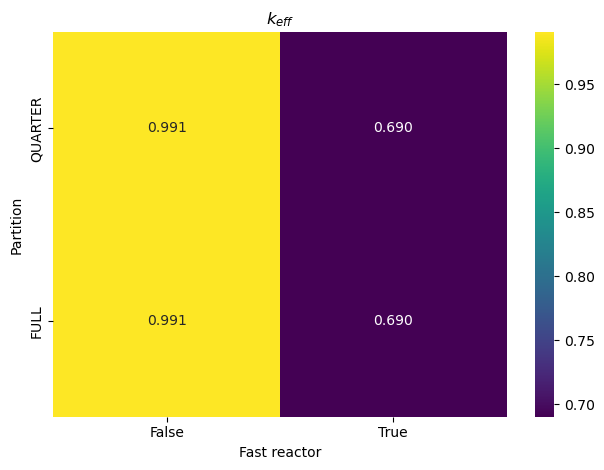

In [5]:
ax = sns.heatmap(pivoted_df_k_eff, annot=True, fmt=".3f", cmap='viridis')
ax.invert_yaxis()
plt.title("$k_{eff}$")
plt.xlabel("Fast reactor")
plt.ylabel("Partition")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "k_eff"))

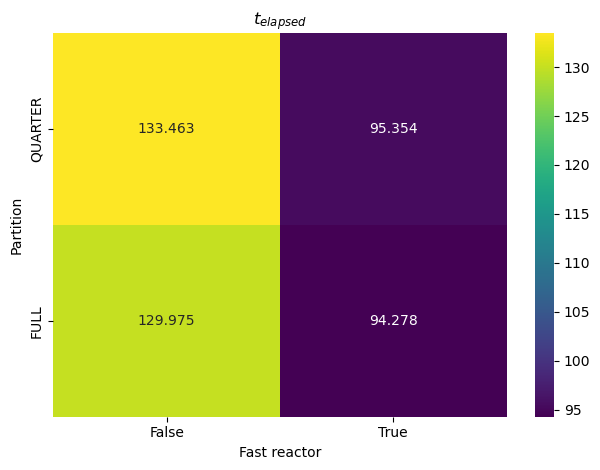

In [6]:
ax = sns.heatmap(pivoted_df_t_elapsed, annot=True, fmt=".3f", cmap='viridis')
ax.invert_yaxis()
plt.title("$t_{elapsed}$")
plt.xlabel("Fast reactor")
plt.ylabel("Partition")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "t_elapsed"))